# Data Import and Cleaning 

#### Datasets from here: 
- https://www.census.gov/programs-surveys/sipp/data/datasets/2008-panel/wave-1.html
- https://www.census.gov/programs-surveys/sipp/data/datasets/2008-panel/wave-2.html
#### Column definition from here: 
- https://www2.census.gov/programs-surveys/sipp/data/datasets/2008/l08puw1.sas
- https://www2.census.gov/programs-surveys/sipp/data/datasets/2008/p08putm1.sas

In [2]:
import numpy as np
import pandas as pd

## Import SIPP data

In [1]:
# sas input statement needs to be cleaned by hand: remove all whitespaces and $-signs e.g. replace ' -' with '-'
# columns that should be kept, need to be defined by hand as well
def import_sipp_data(sas_input_statement, dat_file, columns_keep):
    input_dict = np.loadtxt(sas_input_statement, dtype = str)
    column_lst = input_dict[:, 0].tolist()
    
    colspecs = []
    for string in input_dict[:, 1]:
        tpl_temp = tuple(map(int, string.split('-')))
        tpl_temp = (tpl_temp[0]-1, tpl_temp[1]) # second number should also be corrected?
        colspecs.append(tpl_temp)
    df_raw = pd.read_fwf(dat_file, names=column_lst, colspecs=colspecs)

    df = df_raw[columns_keep]
    del df_raw
    return df

In [266]:
# columns core dataset
clmn_join = ['SSUID', 'SPANEL', 'SWAVE', 'EPPPNUM']

clmn_join_unused = [ 'TFIPSST', 'EOUTCOME', 'SHHADID', 'RFID', 'RFID2', 'EENTAID', 'EPOPSTAT', 'EPPINTVW', 'ESEX', 'ERACE', 'EORIGIN', 'WPFINWGT', 'ERRP', 
                    'EMS', 'EPNMOM', 'EPNDAD', 'EPNGUARD', 'EPNSPOUS', 'RDESGPNT', 'TAGE', 'EEDUCATE']

clmn_general = ['SREFMON', 'EHREFPER', 'RHCALMN', 'RHCALYR', 'TMOVRFLG', 'EHHNUMPP', 'EFSPOUSE', 'RFNKIDS', 'EBORNUS', 'ECITIZEN', 'RENROLL', 'EFKIND', 'RHTYPE']

# make hist for all income categories and combine the small ones into a new 'other' or substract all interesting income streams from total and take the residual.
clmn_income = ['TFEARN', 'TFTOTINC', 'TPEARN', 'TPTOTINC', 'THTRNINC', 'THOTHINC', 'ETENURE', 'THPNDIST', 'THSOCSEC', 'THVETS', 'THLUMPSM', 'THAFDC', 
                'EAST1C', 'THPRPINC', 'TINTINC', 'TDIVINC', 'EAST3B', 'EAST3C', 'EAST3D', 'EAST3E', 'EAST4A' ]

clmn_labor = ['EPAYHR1', 'EPAYHR2', 'TPYRATE1', 'TPYRATE2', 'EJBHRS1', 'EJBHRS2', 'EUNION1', 'EUNION2', 'TMLMSUM', 'EDISABL', 'EDISPREV', 
                'EAWOP', 'EABRE', 'ERSNOWRK', 'EPTRESN', 'EBUSCNTR', 'EJOBCNTR', 'RMWKSAB', 'EPDJBTHN', 'ELKWRK', 'ELAYOFF', 'EHRSALL', 'EMOONLIT', 'RMHRSWK', 'EPTWRK', 
                'RMESR', 'RMWKWJB', 'RWKSPERM', 'EBNO1', 'EBNO2']

columns_core = clmn_join + clmn_join_unused + clmn_general + clmn_income + clmn_labor
print('length core columns: ', len(columns_core))

# columns topical dataset
clmn_join

clmn_rebate = ['EREBATE', 'ERBAMTH', 'ERBATAMT', 'ERBATTYP', 'EREBATOC']

columns_topical = clmn_join + clmn_rebate
print('length topical columns: ', len(columns_topical))

# potential columns to add: TMTHRNT (total rent), RHCHANGE(change in HH composition), RFCHANGE(change in family composition)

length core columns:  88
length topical columns:  9


In [5]:
w2_core = import_sipp_data('input_core.txt', '/Users/maxweber/Desktop/DataMasterThesis/l08puw2.dat', columns_core)
print('w2 core imported')
w2_core.to_csv('/Users/maxweber/Desktop/DataMasterThesis/core_w2.csv') 
print('w2 core exported to csv')

w1_core = import_sipp_data('input_core.txt', '/Users/maxweber/Desktop/DataMasterThesis/l08puw1.dat', columns_core)
print('w1 core imported')
w1_core.to_csv('/Users/maxweber/Desktop/DataMasterThesis/core_w1.csv') 
print('w1 core exported to csv')

w1_topical = import_sipp_data('input_topical_w1.txt', '/Users/maxweber/Desktop/DataMasterThesis/p08putm1.dat', columns_topical)
print('w1 topical imported')
w1_topical.to_csv('/Users/maxweber/Desktop/DataMasterThesis/topical_w1.csv') 
print('w1 topical exported to csv')

w2_topical = import_sipp_data('input_topical_w2.txt', '/Users/maxweber/Desktop/DataMasterThesis/p08putm2.dat', columns_topical)
print('w2 topical imported')
w2_topical.to_csv('/Users/maxweber/Desktop/DataMasterThesis/topical_w2.csv') 
print('w2 topical exported to csv')

[(0, 5), (5, 17), (17, 21), (21, 23), (23, 24), (24, 25), (25, 27), (27, 31), (31, 34), (34, 37), (37, 38), (38, 41), (41, 43), (43, 45), (45, 48), (48, 50), (50, 52), (52, 54), (54, 58), (58, 61), (61, 62), (62, 72), (72, 73), (73, 74), (74, 76), (76, 77), (77, 78), (78, 80), (80, 81), (81, 83), (83, 84), (84, 90), (90, 91), (91, 93), (93, 94), (94, 96), (96, 97), (97, 99), (99, 100), (100, 102), (102, 104), (104, 106), (106, 107), (107, 112), (112, 113), (113, 115), (115, 116), (116, 118), (118, 120), (120, 121), (121, 123), (123, 124), (124, 126), (126, 127), (127, 129), (129, 131), (131, 132), (132, 134), (134, 135), (135, 136), (136, 143), (143, 151), (151, 158), (158, 165), (165, 173), (173, 175), (175, 177), (177, 179), (179, 184), (184, 191), (191, 199), (199, 205), (205, 211), (211, 217), (217, 223), (223, 229), (229, 235), (235, 241), (241, 244), (244, 247), (247, 249), (249, 253), (253, 257), (257, 259), (259, 260), (260, 262), (262, 264), (264, 266), (266, 268), (268, 270),

In [283]:
w1_core = pd.read_csv('/Users/maxweber/Desktop/DataMasterThesis/core_w1.csv')
w2_core = pd.read_csv('/Users/maxweber/Desktop/DataMasterThesis/core_w2.csv')
w1_topical = pd.read_csv('/Users/maxweber/Desktop/DataMasterThesis/topical_w1.csv')
w2_topical = pd.read_csv('/Users/maxweber/Desktop/DataMasterThesis/topical_w2.csv')

In [284]:
print(w1_core.shape)
print(w1_topical.shape)
w1_full = w1_core.merge(w1_topical[clmn_join+clmn_rebate], how = 'left', on = clmn_join)
w1_full.shape

print(w2_core.shape)
print(w2_topical.shape)
w2_full = w2_core.merge(w2_topical[clmn_join+clmn_rebate], how = 'left', on = clmn_join)
w2_full.shape

df = pd.concat([w1_full, w2_full])
df.drop('Unnamed: 0', inplace = True, axis=1)

df.to_csv('/Users/maxweber/Desktop/DataMasterThesis/full_sipp.csv')
print(df.shape)
del [w1_core, w2_core, w1_topical, w2_topical]

df.head()

(421911, 88)
(105663, 31)
(392702, 88)
(98504, 31)
(814613, 92)


,SSUID,SPANEL,SWAVE,TFIPSST,EOUTCOME,SHHADID,RFID,RFID2,EENTAID,EPPPNUM,...,RMESR,RMWKWJB,RWKSPERM,EBNO1,EBNO2,EREBATE,ERBAMTH,ERBATAMT,ERBATTYP,EREBATOC
0,19128000276,2008,1,12,201,11,1,1,11,101,...,8,0,4,-1,-1,2.0,-1.0,0.0,-1.0,-1.0
1,19128000276,2008,1,12,201,11,2,2,11,101,...,8,0,5,-1,-1,2.0,-1.0,0.0,-1.0,-1.0
2,19128000276,2008,1,12,201,11,3,3,11,101,...,8,0,4,-1,-1,2.0,-1.0,0.0,-1.0,-1.0
3,19128000276,2008,1,12,201,11,4,4,11,101,...,7,0,4,-1,-1,2.0,-1.0,0.0,-1.0,-1.0
4,19128000276,2008,1,12,201,11,1,1,11,102,...,8,0,4,-1,-1,2.0,-1.0,0.0,-1.0,-1.0


In [285]:
df.columns

Index(['SSUID', 'SPANEL', 'SWAVE', 'TFIPSST', 'EOUTCOME', 'SHHADID', 'RFID',
       'RFID2', 'EENTAID', 'EPPPNUM', 'EPOPSTAT', 'EPPINTVW', 'ESEX', 'ERACE',
       'EORIGIN', 'WPFINWGT', 'ERRP', 'EMS', 'EPNMOM', 'EPNDAD', 'EPNGUARD',
       'EPNSPOUS', 'RDESGPNT', 'TAGE', 'EEDUCATE', 'SREFMON', 'EHREFPER',
       'RHCALMN', 'RHCALYR', 'TMOVRFLG', 'EHHNUMPP', 'EFSPOUSE', 'RFNKIDS',
       'EBORNUS', 'ECITIZEN', 'RENROLL', 'TFEARN', 'TFTOTINC', 'TPEARN',
       'TPTOTINC', 'THTRNINC', 'THOTHINC', 'ETENURE', 'THPNDIST', 'THSOCSEC',
       'THVETS', 'THLUMPSM', 'THAFDC', 'EAST1C', 'THPRPINC', 'TINTINC',
       'TDIVINC', 'EAST3B', 'EAST3C', 'EAST3D', 'EAST3E', 'EAST4A', 'EPAYHR1',
       'EPAYHR2', 'TPYRATE1', 'TPYRATE2', 'EJBHRS1', 'EJBHRS2', 'EUNION1',
       'EUNION2', 'TMLMSUM', 'EDISABL', 'EDISPREV', 'EAWOP', 'EABRE',
       'ERSNOWRK', 'EPTRESN', 'EBUSCNTR', 'EJOBCNTR', 'RMWKSAB', 'EPDJBTHN',
       'ELKWRK', 'ELAYOFF', 'EHRSALL', 'EMOONLIT', 'RMHRSWK', 'EPTWRK',
       'RMESR', 'RMWK

In [639]:
df = pd.read_csv('/Users/maxweber/Desktop/DataMasterThesis/full_sipp.csv')
df.drop('Unnamed: 0', inplace = True, axis=1)
df.shape

(814613, 92)

## Data Cleaning and Feature Engineering

In [640]:
df['pp'] = df.groupby(['SSUID','EPPPNUM']).ngroup()
df.set_index('pp', inplace = True)
print('unique index: ',len(df.index.unique())) #95577 unique
pp_count = df.groupby(['pp'], as_index=False).size() # columns: pp and size
pp_count

df = df.merge(pp_count, how = 'outer', on = 'pp')
df = df[df['size']== 8]
df.drop('size', axis=1, inplace = True)

df.shape # 764.616 from 814.613 before

unique index:  108280


(764616, 93)

(587768, 95)

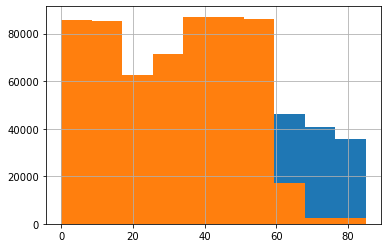

In [641]:
#Powell: I require the head of the household to be between 25 and 60 years old
# EHREFPER = EPPPNUM and TAGE => 25 and TAGE <= 60 (this can be optimized by looking at first or last month of observed timeframe)
df['TAGE'].describe()
min_tage = df.groupby(df.index)['TAGE'].min().rename('min_tage')
max_tage = df.groupby(df.index)['TAGE'].max().rename('max_tage')

df = df.merge(min_tage, how = 'left', left_index = True, right_index = True)
df = df.merge(max_tage, how = 'left', left_index = True, right_index = True)

ssuids_age = df[(df['EHREFPER'] == df['EPPPNUM']) & (df['min_tage']>= 25)  & (df['max_tage'] <= 60)]['SSUID'].unique()

df[~df['SSUID'].isin(ssuids_age)]['TAGE'].hist()
df[df['SSUID'].isin(ssuids_age)]['TAGE'].hist()
df = df[df['SSUID'].isin(ssuids_age)]
# seems reasonable. next step is to aggregate to houshold level to further reduce #of HH
df.shape

In [642]:
print('Number of housholds: ', len(df[df['SSUID'].isin(ssuids_age)]['SSUID'].unique()))

Number of housholds:  26238


In [643]:
# create the total month variable with year and month
def get_total_month(year,month):
    if year == 2009:
        return month+12
    else:
        return month
        
df['month_total'] = df.apply(lambda x: get_total_month(x['RHCALYR'],x['RHCALMN']),axis=1)

np.nan can only be conditioned on by np.isna() and pd.isnull() <br>
np.nan == np.nan -> False

In [644]:
# correct the rebated if EREBATE = 2 -> EREBATE = 0; if EREBATE = -1 -> EREBATE = np.NaN
df['erebate'] = df['EREBATE']
print(df[~df['erebate'].isnull()]['erebate'].unique()) # 2 -> 0 & -1 -> np.NaN
df['erebate'] = df['EREBATE'].replace({2 : 0, -1 : np.NaN})

df['erbamth'] = df['ERBAMTH'].replace(-1, np.NaN)
df['erebatoc'] = df['EREBATOC'].replace(-1, np.NaN)
df['erbattyp'] = df['ERBATTYP'].replace({2 : 0, -1 : np.NaN})

[ 2. -1.  1.]


array([[<AxesSubplot:title={'center':'erebate'}>,
        <AxesSubplot:title={'center':'erbamth'}>],
       [<AxesSubplot:title={'center':'erbattyp'}>,
        <AxesSubplot:title={'center':'erebatoc'}>]], dtype=object)

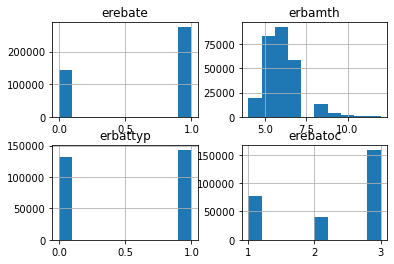

In [645]:
df[['erebate','erbamth', 'erbattyp', 'erebatoc']].hist()

In [646]:
df['erebate'].describe()

# so far not the number from Powell. Different if aggregeated to HH?

count    418076.000000
mean          0.659383
std           0.473917
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: erebate, dtype: float64

In [647]:
# generate dummy for change in maritial status from EMS: 1 if married, 0 if not married or spouse not present

df['spouse'] = df['EMS'].replace(to_replace = [2,3,4,5,6], value = 0)
spouse_sum = df.groupby(['pp'])['spouse'].sum()
df = df.merge(df.groupby(['pp'])['spouse'].sum(), on = 'pp', how = 'left' )
df['spouse'] = df['spouse_x']
df['spouse_sum'] = df['spouse_y']
df.drop('spouse_x', axis = 1, inplace = True)
df.drop('spouse_y', axis = 1, inplace = True)

#houshold[['spouse', 'spouse_sum']].describe()
#houshold['spouse_sum'].unique() 

def get_change_spouse(spouse_sum):
    if spouse_sum == 0 or spouse_sum == 8 :
        return 0
    else:
        return 1
        
df['change_spouse'] = df.apply(lambda x: get_change_spouse(x['spouse_sum']),axis=1)

print(df[['change_spouse', 'spouse_sum']].describe()) # in Powell dataset the mean of change_spouse is 0.006
df.drop('spouse_sum', axis = 1, inplace = True)

       change_spouse     spouse_sum
count  587768.000000  587768.000000
mean        0.007568       3.160172
std         0.086662       3.897244
min         0.000000       0.000000
25%         0.000000       0.000000
50%         0.000000       0.000000
75%         0.000000       8.000000
max         1.000000       8.000000


In [859]:
# define lag_time as time relative to the month of rebate. Use this to define lag-dummies used in the regression.
df['lag_time'] =  df['month_total'] - df['erbamth']

# use on df without NaN in lag_time period
def get_pivoted_feature(df, col_name):
    rslt_df = df.pivot(columns = 'lag_time', values = col_name)
    clm_lst = []
    for i in range(len(rslt_df.columns)):
        clm_lst.append(col_name +  '_' + str(rslt_df.columns[i]))
    rslt_df.columns = clm_lst
    return rslt_df

In [860]:
# create dummies for the rebate dummy and the month of rebate
pivoted = get_pivoted_feature(df[df['lag_time'].notnull()], 'erebate')
df = pivoted.merge(df, how = 'outer', left_index = True, right_index=True)
print(df.shape)

df[pivoted.columns] = df[pivoted.columns].replace(np.NaN,0)
df[df['erebate'].notnull()][pivoted.columns] # replaced the nan with 0.0

(587768, 159)


,erebate_-6.0,erebate_-5.0,erebate_-4.0,erebate_-3.0,erebate_-2.0,erebate_-1.0,erebate_0.0,erebate_1.0,erebate_2.0,erebate_3.0,erebate_4.0,erebate_5.0,erebate_6.0,erebate_7.0,erebate_8.0,erebate_9.0,erebate_10.0,erebate_11.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
587740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
587741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
587742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## kann weg: create dummy for erebate in one column: if erebate = 1 and erbamth == total_month: 1  else: 0
df['rebdum '] = 0

def set_rebdum(month_total, erebate, ERBAMTH):
    if erebate == 1 and ERBAMTH == month_total:
        return 1
    else:
        return 0

df['rebdum'] = df.apply(lambda x: set_rebdum(x['month_total'], x['erebate'], x['ERBAMTH']),axis=1)
df['rebdum'].hist()

In [861]:
df[df['erebate']==1][['SSUID','EPPPNUM']]
df[df['SSUID']==19128038046][pivoted.columns]

,erebate_-6.0,erebate_-5.0,erebate_-4.0,erebate_-3.0,erebate_-2.0,erebate_-1.0,erebate_0.0,erebate_1.0,erebate_2.0,erebate_3.0,erebate_4.0,erebate_5.0,erebate_6.0,erebate_7.0,erebate_8.0,erebate_9.0,erebate_10.0,erebate_11.0
56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Aggregate to houshold level (SSUID)
modified/aggregated variables in lower caps

In [842]:
pivoted.columns

Index(['erebate_-6.0', 'erebate_-5.0', 'erebate_-4.0', 'erebate_-3.0',
       'erebate_-2.0', 'erebate_-1.0', 'erebate_0.0', 'erebate_1.0',
       'erebate_2.0', 'erebate_3.0', 'erebate_4.0', 'erebate_5.0',
       'erebate_6.0', 'erebate_7.0', 'erebate_8.0', 'erebate_9.0',
       'erebate_10.0', 'erebate_11.0'],
      dtype='object')

In [862]:
houshold = df.groupby(['SSUID', 'month_total'])[['SSUID', 'TFEARN', 'month_total', 'erbamth','erebate_-1.0', 
                                                'erebate_0.0', 'erebate_1.0','erebate_2.0', 'erebate_3.0', 'erebate_4.0', 'ERBATAMT']].mean()
houshold[['ERBATAMT', 'TFEARN']].describe()

,ERBATAMT,TFEARN
count,209904.000000,209904.00000
mean,293.105179,5126.52427
std,227.596681,5712.13357
min,0.000000,-46667.00000
25%,90.000000,1591.00000
50%,300.000000,3756.00000
75%,450.000000,6933.00000
max,1800.000000,98083.00000


In [863]:
houshold = df.groupby(['SSUID', 'month_total'])[['SSUID', 'TPEARN', 'month_total', 'erbamth','erebate_-1.0', 
                                                'erebate_0.0', 'erebate_1.0','erebate_2.0', 'erebate_3.0', 'erebate_4.0', 'ERBATAMT']].agg({'month_total': 'first',
                                                                                                                                                'TPEARN': 'sum',
                                                                                                                                                'erbamth': 'first',
                                                                                                                                                'erebate_-1.0': 'first', 
                                                                                                                                                'erebate_0.0': 'first',
                                                                                                                                                 'erebate_1.0': 'first',
                                                                                                                                                 'erebate_2.0': 'first', 
                                                                                                                                                 'erebate_3.0': 'first', 
                                                                                                                                                 'erebate_4.0': 'first',
                                                                                                                                                 'ERBATAMT': 'first'})
houshold[['ERBATAMT', 'TPEARN']].describe()

,ERBATAMT,TPEARN
count,209904.000000,209904.000000
mean,407.518027,5346.575682
std,327.563129,5806.775889
min,0.000000,-46667.000000
25%,0.000000,1732.000000
50%,450.000000,4033.000000
75%,600.000000,7233.000000
max,2250.000000,98083.000000


In [864]:
houshold.loc[955958398688]

,month_total,TPEARN,erbamth,erebate_-1.0,erebate_0.0,erebate_1.0,erebate_2.0,erebate_3.0,erebate_4.0,ERBATAMT
month_total,,,,,,,,,,
7.0,7.0,10000,9.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0
8.0,8.0,10000,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1000.0
9.0,9.0,10000,9.0,0.0,1.0,0.0,0.0,0.0,0.0,1000.0
10.0,10.0,10000,9.0,0.0,0.0,1.0,0.0,0.0,0.0,1000.0
11.0,11.0,10000,8.0,0.0,0.0,0.0,0.0,1.0,0.0,900.0
12.0,12.0,10000,8.0,0.0,0.0,0.0,0.0,0.0,1.0,900.0
13.0,13.0,10000,8.0,0.0,0.0,0.0,0.0,0.0,0.0,900.0
14.0,14.0,10000,8.0,0.0,0.0,0.0,0.0,0.0,0.0,900.0


In [869]:
exog_vars = houshold[['erebate_-1.0', 'erebate_0.0', 'erebate_1.0','erebate_2.0', 'erebate_3.0', 'erebate_4.0']].multiply(houshold['ERBATAMT'], axis = 'index')
exog = sm.add_constant(exog_vars)

rslt = PanelOLS(houshold['TPEARN'], exog, entity_effects = True, time_effects = True, check_rank = True, drop_absorbed=True)

rslt.fit()

/Users/maxweber/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Dep. Variable:,TPEARN,R-squared:,1.306e-05
Estimator:,PanelOLS,R-squared (Between):,-2.214e-05
No. Observations:,209904,R-squared (Within):,-4.589e-05
Date:,"Tue, May 24 2022",R-squared (Overall):,-2.505e-05
Time:,15:49:02,Log-likelihood,-1.897e+06
Cov. Estimator:,Unadjusted,,
,,F-statistic:,0.3998
Entities:,26238,P-value,0.8796
Avg Obs:,8.0000,Distribution:,"F(6,183650)"
Min Obs:,8.0000,,
Max Obs:,8.0000,F-statistic (robust):,0.3998


# Data Description

In [867]:
houshold.index

MultiIndex([( 19128000276,  6.0),
            ( 19128000276,  7.0),
            ( 19128000276,  8.0),
            ( 19128000276,  9.0),
            ( 19128000276, 10.0),
            ( 19128000276, 11.0),
            ( 19128000276, 12.0),
            ( 19128000276, 13.0),
            ( 19128000932,  6.0),
            ( 19128000932,  7.0),
            ...
            (955925986857, 13.0),
            (955925986857, 14.0),
            (955958398688,  7.0),
            (955958398688,  8.0),
            (955958398688,  9.0),
            (955958398688, 10.0),
            (955958398688, 11.0),
            (955958398688, 12.0),
            (955958398688, 13.0),
            (955958398688, 14.0)],
           names=['SSUID', 'month_total'], length=209904)

## Open Questions

- SSUID leading zeros are gone since not string type?
- Do I need to include the weightings?
- Are houshold rebated at the sam time or does this cause problems with aggregation?
- Are untreated HHs dropped in Powell or Parker?
- exclude observations where the rebate month is before the first observation? (since the HH is only observed in the treated state)
- There are observations with different rebate info depending on the wave -> how to handle/is the join wrong?
- 66% instead of 81% rebated -> changes after grouping for HHs and subsetting?
 >  Powell: Almost all (87%) of the sample reports labor earnings for all 8 months. A small portion (9.5%) of the sample is only in one of the waves but reports for all 4 months in that wave. The analysis excludes these households and the remaining households, which report for fewer than 8 months.
- should I include famsize > 6 => famsize == 6?
- is there a difference between houshold and familysize? combine?
- is it viable to join earn_male/earn_female/spouse via SSUID and EPPPNUM if not able to recreate?
- the pp_count creation with count() instead of size()??
- subset on missing data instead of size? before dropna, there are probably always 8 observations but maybe with nan in most columns.
- check if the new join (core + topical) is correct or creates problems
- THEARN vs TFEARN ?


## ToDo Data Cleaning
- replace the dummy variables as 1, 0, np.NaN 
- subset on interview status? if missing data -> drop?
- EOUTCOME  drop the 270s numbers?
- Are untreated HHs dropped in Powell or Parker?
> analysis on HH level: tot_income, higher income, lower income, difference in income, sex of top earner
- aggregate to HH level: df_hh (are HHs rebated at the same time?)
- compare to houshold dataframe and individual dataframe
- Check whether many hh have different info on rebate in their wave1 and 2 data.
- categrocial variables to string


## ToDo Data Description
- (make list of continous and categorical variables to make dummy creation easier)
- categrocial variables to string
- (make star scheme to map the codes to their description.)
- explore and describe each variable used graphically where possible

## ToDo Analysis
- Baseline analysis
- Select grouping variables 
- Select ranges for each group
- compute average rebate for each group

# Variable names of modified data in lower caps to show that not the original data is used.

In [325]:
%pip install linearmodels

     |████████████████████████████████| 1.5 MB 5.8 MB/s eta 0:00:01
     |████████████████████████████████| 68 kB 14.3 MB/s eta 0:00:01
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

formulaic 0.3.4 requires scipy>=1.6, but you'll have scipy 1.5.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [543]:
# Fixed effects regression:
from linearmodels import PanelOLS
import statsmodels.api as sm

In [778]:
data = df.reset_index().set_index(['pp','month_total'])
exog_vars = ['erebate_-1.0', 'erebate_0.0', 'erebate_1.0','erebate_2.0', 'erebate_3.0', 'erebate_4.0']
exog = sm.add_constant(data[exog_vars])

rslt = PanelOLS(data['TFEARN'], exog, entity_effects = True, time_effects = True, check_rank = False, drop_absorbed=True)

rslt.fit()

Dep. Variable:,TFEARN,R-squared:,4.421e-05
Estimator:,PanelOLS,R-squared (Between):,-7.33e-05
No. Observations:,587768,R-squared (Within):,-5.576e-05
Date:,"Tue, May 24 2022",R-squared (Overall):,-7.114e-05
Time:,13:18:36,Log-likelihood,-5.339e+06
Cov. Estimator:,Unadjusted,,
,,F-statistic:,3.7897
Entities:,73471,P-value,0.0009
Avg Obs:,8.0000,Distribution:,"F(6,514281)"
Min Obs:,8.0000,,
Max Obs:,8.0000,F-statistic (robust):,3.7897


## todo Dienstag:
- aggregation auf HH ebene konzeptionieren und anfangen

In [624]:
df = pd.read_csv('/Users/maxweber/Desktop/DataMasterThesis/full_sipp.csv')
df.drop('Unnamed: 0', inplace = True, axis=1)